In [1]:
import tensorflow as tf
import keras
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization, ZeroPadding2D
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#------------------------------
#cpu - gpu configuration
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) 
keras.backend.set_session(sess)
#------------------------------
#variables
height = 48
width = 48
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 64
epochs = 1000
#------------------------------
#read kaggle facial expression recognition challenge dataset (fer2013.csv)
#https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge

with open("../images/fer2013/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

#------------------------------
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

#------------------------------
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

#------------------------------
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)
x_train -= x_train_mean
x_test -= x_test_mean
x_train /= x_train_std 
x_test /= x_test_std

x_train = x_train.reshape(x_train.shape[0], width, height, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], width, height, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

/home/connor/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


number of instances:  35888
instance length:  2304
28709 train samples
3589 test samples


In [2]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))


gen = ImageDataGenerator()
val_gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size, shuffle=True)
valid_generator = val_gen.flow(x_test, y_test, batch_size=batch_size)

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.75, patience=3, verbose=1)

early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=11, verbose=1, mode='auto')

checkpointer = ModelCheckpoint('../models/MODEL_G.h5', monitor='val_acc', verbose=1, save_best_only=True)

tensorboard = TensorBoard(log_dir='../logs/G')

steps_train = train_generator.n//train_generator.batch_size
steps_valid = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(train_generator, 
                                  steps_per_epoch=steps_train, 
                                  validation_steps = steps_valid,
                                  epochs=epochs, 
                                  validation_data=valid_generator,
                                  callbacks=[early_stopper, checkpointer, tensorboard])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 128)       512       
__________

448/448 [==============================] - 38s 85ms/step - loss: 0.5029 - acc: 0.8376 - val_loss: 1.5056 - val_acc: 0.6011

Epoch 00020: val_acc did not improve from 0.60823
Epoch 21/1000
448/448 [==============================] - 38s 85ms/step - loss: 0.4687 - acc: 0.8525 - val_loss: 1.4808 - val_acc: 0.6009

Epoch 00021: val_acc did not improve from 0.60823
Epoch 22/1000
448/448 [==============================] - 38s 85ms/step - loss: 0.3915 - acc: 0.8767 - val_loss: 1.5436 - val_acc: 0.6057

Epoch 00022: val_acc did not improve from 0.60823
Epoch 23/1000
448/448 [==============================] - 38s 85ms/step - loss: 0.3628 - acc: 0.8886 - val_loss: 1.6595 - val_acc: 0.6060

Epoch 00023: val_acc did not improve from 0.60823
Epoch 24/1000
448/448 [==============================] - 38s 85ms/step - loss: 0.3178 - acc: 0.9047 - val_loss: 1.7410 - val_acc: 0.6074

Epoch 00024: val_acc did not improve from 0.60823
Epoch 25/1000
448/448 [==============================] - 38s 85ms/step - l

Text(0.5,1,'Accuracy Curves')

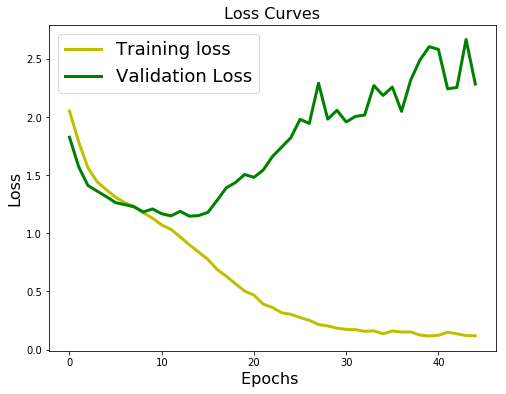

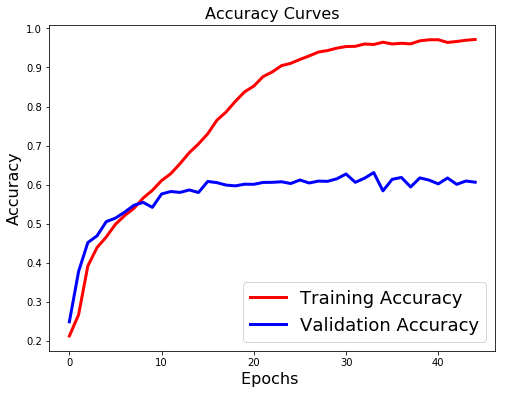

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'y',linewidth=3.0)
plt.plot(history.history['val_loss'],'g',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
# Accuracy curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)